<a href="https://colab.research.google.com/github/delibae/AI_study/blob/main/honeybee.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Import

In [2]:
#####################################
# Libraries
#####################################
# Common libs
import pandas as pd
import numpy as np
import sys
import os
import random
from pathlib import Path

# Image processing
import imageio
import skimage
import skimage.io
import skimage.transform
#from skimage.transform import rescale, resize, downscale_local_mean

# Charts
import matplotlib.pyplot as plt
import seaborn as sns


# ML
import scipy
from sklearn.model_selection import train_test_split
from sklearn import metrics

#from sklearn.preprocessing import OneHotEncoder
from keras import optimizers
from keras.models import Sequential
from keras.layers import Dense, Conv2D, Flatten, MaxPool2D, Dropout, BatchNormalization,LeakyReLU
from keras.preprocessing.image import ImageDataGenerator
from keras.callbacks import ModelCheckpoint, Callback, EarlyStopping, ReduceLROnPlateau
from keras.utils import to_categorical
import tensorflow

#####################################
# Settings
#####################################

# Set random seed to make results reproducable
np.random.seed(42)
tensorflow.random.set_seed(42)

# Global variables
img_folder='/content/drive/MyDrive/data/archive/bee_imgs/bee_imgs/'
img_width=100
img_height=100
img_channels=3

# Load Data

In [3]:
bees=pd.read_csv('/content/drive/MyDrive/data/archive/bee_data.csv', 
                index_col=False,  
                parse_dates={'datetime':[1,2]},
                dtype={'subspecies':'category', 'health':'category','caste':'category'})
#bees = bees.sample(300)

# Will use this function later to load images of preprocessed bees
# Don't load images just from the start to save memory for preprocessing steps
def read_img(file):
    """
    Read and resize img, adjust channels. 
    Caution: This function is not independent, it uses global vars: img_folder, img_channels
    @param file: file name without full path
    """
    img = skimage.io.imread(img_folder + file)
    img = skimage.transform.resize(img, (img_width, img_height), mode='reflect')
    return img[:,:,:img_channels]

# Cannot impute nans, drop them
bees.dropna(inplace=True)

# Some image files don't exist. Leave only bees with available images.
img_exists = bees['file'].apply(lambda f: os.path.exists(img_folder + f))
print(img_exists)
bees = bees[img_exists]

bees.head()

print(bees)

0       True
1       True
2       True
3       True
4       True
        ... 
5167    True
5168    True
5169    True
5170    True
5171    True
Name: file, Length: 5172, dtype: bool
                datetime         file           location  zip code subspecies  \
0    2018-08-28 16:07:00  041_066.png     Alvin, TX, USA     77511         -1   
1    2018-08-28 16:07:00  041_072.png     Alvin, TX, USA     77511         -1   
2    2018-08-28 16:07:00  041_073.png     Alvin, TX, USA     77511         -1   
3    2018-08-28 16:07:00  041_067.png     Alvin, TX, USA     77511         -1   
4    2018-08-28 16:07:00  041_059.png     Alvin, TX, USA     77511         -1   
...                  ...          ...                ...       ...        ...   
5167 2018-08-20 10:03:00  027_011.png  San Jose, CA, USA     95124         -1   
5168 2018-08-20 10:03:00  027_007.png  San Jose, CA, USA     95124         -1   
5169 2018-08-20 10:03:00  027_013.png  San Jose, CA, USA     95124         -1   
5170 2018

# Dataset Analysis

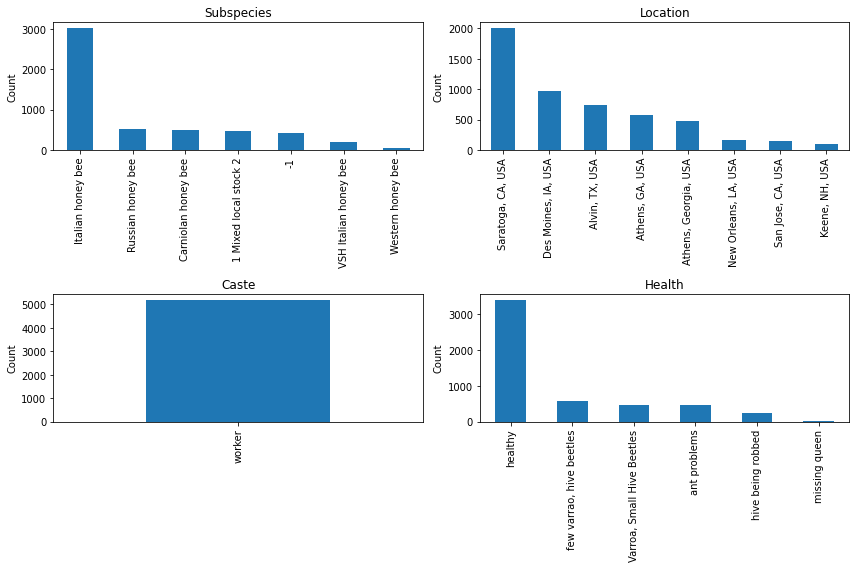

In [4]:
f, ax = plt.subplots(nrows=2, ncols=2, figsize=(12,8))

bees.subspecies.value_counts().plot(kind='bar',ax=ax[0, 0])
ax[0,0].set_ylabel('Count')
ax[0,0].set_title('Subspecies')

bees.location.value_counts().plot(kind='bar', ax=ax[0, 1])
ax[0,1].set_title('Location')
ax[0,1].set_ylabel('Count')

bees.caste.value_counts().plot(kind='bar', ax=ax[1, 0])
ax[1,0].set_title('Caste')
ax[1,0].set_ylabel('Count')

bees.health.value_counts().plot(kind='bar', ax=ax[1,1])
ax[1,1].set_title('Health')
ax[1,1].set_ylabel('Count')

f.subplots_adjust(hspace=0.7)
f.tight_layout()
plt.show()

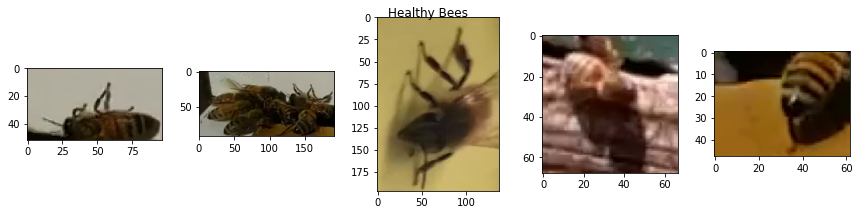

In [5]:
ncols = 5
healthy = bees[bees['health'] == 'healthy'].sample(ncols)

f, ax = plt.subplots(nrows=1,ncols=ncols, figsize=(12,3))
# Read image of original size from disk, because bees['img'] contains resized numpy array
for i in range(0,5): 
    file = img_folder + healthy.iloc[i]['file']
    ax[i].imshow(imageio.imread(file))

plt.suptitle("Healthy Bees")
plt.tight_layout()
plt.show()

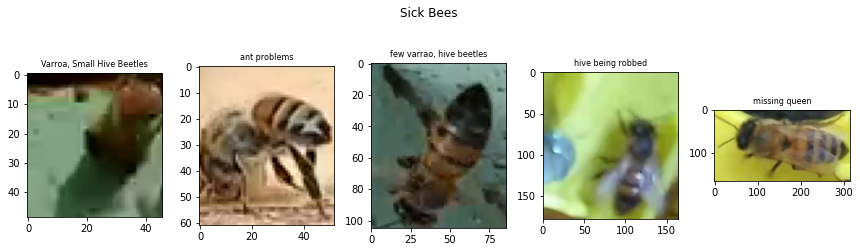

In [6]:
health_cats = bees['health'].cat.categories
f, ax = plt.subplots(1, health_cats.size-1, figsize=(12,4))
i=0
for c in health_cats:
    if c == 'healthy': continue
    bee = bees[bees['health'] == c].sample(1).iloc[0]
    ax[i].imshow(imageio.imread(img_folder + bee['file']))
    ax[i].set_title(bee['health'], fontsize=8)
    i += 1
    
plt.suptitle("Sick Bees")    
plt.tight_layout()
plt.show()

# Trim Data

In [7]:
print(bees)

                datetime         file           location  zip code subspecies  \
0    2018-08-28 16:07:00  041_066.png     Alvin, TX, USA     77511         -1   
1    2018-08-28 16:07:00  041_072.png     Alvin, TX, USA     77511         -1   
2    2018-08-28 16:07:00  041_073.png     Alvin, TX, USA     77511         -1   
3    2018-08-28 16:07:00  041_067.png     Alvin, TX, USA     77511         -1   
4    2018-08-28 16:07:00  041_059.png     Alvin, TX, USA     77511         -1   
...                  ...          ...                ...       ...        ...   
5167 2018-08-20 10:03:00  027_011.png  San Jose, CA, USA     95124         -1   
5168 2018-08-20 10:03:00  027_007.png  San Jose, CA, USA     95124         -1   
5169 2018-08-20 10:03:00  027_013.png  San Jose, CA, USA     95124         -1   
5170 2018-08-20 10:03:00  027_012.png  San Jose, CA, USA     95124         -1   
5171 2018-08-20 10:03:00  027_014.png  San Jose, CA, USA     95124         -1   

                 health  po

In [8]:
bees = bees.drop(columns=['datetime','location','zip code','subspecies','pollen_carrying','caste'])


In [9]:
bees.head()

,file,health
0,041_066.png,hive being robbed
1,041_072.png,hive being robbed
2,041_073.png,hive being robbed
3,041_067.png,hive being robbed
4,041_059.png,hive being robbed


In [10]:
label_list = bees['health'].unique().to_list()

In [11]:
print(label_list)

['hive being robbed', 'healthy', 'few varrao, hive beetles', 'ant problems', 'missing queen', 'Varroa, Small Hive Beetles']


In [12]:
def add(valid):
  index = label_list.index(valid)
  return index

In [13]:
bees['label'] = bees.apply(lambda row : add(row['health']), axis = 1)

In [14]:
bees = bees.drop(columns = 'health')

In [15]:
print(bees)

             file  label
0     041_066.png      0
1     041_072.png      0
2     041_073.png      0
3     041_067.png      0
4     041_059.png      0
...           ...    ...
5167  027_011.png      1
5168  027_007.png      1
5169  027_013.png      1
5170  027_012.png      1
5171  027_014.png      1

[5172 rows x 2 columns]


In [16]:
bees['file_name'] = bees.apply(lambda row : (img_folder + row['file']), axis = 1)

In [17]:
print(bees.iloc[0]['label'])
print(bees)

0
             file  label                                          file_name
0     041_066.png      0  /content/drive/MyDrive/data/archive/bee_imgs/b...
1     041_072.png      0  /content/drive/MyDrive/data/archive/bee_imgs/b...
2     041_073.png      0  /content/drive/MyDrive/data/archive/bee_imgs/b...
3     041_067.png      0  /content/drive/MyDrive/data/archive/bee_imgs/b...
4     041_059.png      0  /content/drive/MyDrive/data/archive/bee_imgs/b...
...           ...    ...                                                ...
5167  027_011.png      1  /content/drive/MyDrive/data/archive/bee_imgs/b...
5168  027_007.png      1  /content/drive/MyDrive/data/archive/bee_imgs/b...
5169  027_013.png      1  /content/drive/MyDrive/data/archive/bee_imgs/b...
5170  027_012.png      1  /content/drive/MyDrive/data/archive/bee_imgs/b...
5171  027_014.png      1  /content/drive/MyDrive/data/archive/bee_imgs/b...

[5172 rows x 3 columns]


In [18]:
bees['label'].value_counts()

1    3384
2     579
5     472
3     457
0     251
4      29
Name: label, dtype: int64

In [111]:
train, valid = train_test_split(bees, train_size=.8, shuffle=True, random_state=123, stratify=bees['label'])

In [112]:
train = train.drop(columns = ['file'])

valid = valid.drop(columns = ['file'])


In [113]:
train['label'].value_counts()


1    2707
2     463
5     377
3     366
0     201
4      23
Name: label, dtype: int64

In [114]:
valid['label'].value_counts()

1    677
2    116
5     95
3     91
0     50
4      6
Name: label, dtype: int64

In [115]:
print(train)

      label                                          file_name
3295      1  /content/drive/MyDrive/data/archive/bee_imgs/b...
1096      3  /content/drive/MyDrive/data/archive/bee_imgs/b...
2235      1  /content/drive/MyDrive/data/archive/bee_imgs/b...
4380      5  /content/drive/MyDrive/data/archive/bee_imgs/b...
4733      1  /content/drive/MyDrive/data/archive/bee_imgs/b...
...     ...                                                ...
4597      5  /content/drive/MyDrive/data/archive/bee_imgs/b...
749       3  /content/drive/MyDrive/data/archive/bee_imgs/b...
750       3  /content/drive/MyDrive/data/archive/bee_imgs/b...
1528      2  /content/drive/MyDrive/data/archive/bee_imgs/b...
938       3  /content/drive/MyDrive/data/archive/bee_imgs/b...

[4137 rows x 2 columns]


In [116]:
print(valid)

      label                                          file_name
2260      1  /content/drive/MyDrive/data/archive/bee_imgs/b...
2255      1  /content/drive/MyDrive/data/archive/bee_imgs/b...
1101      3  /content/drive/MyDrive/data/archive/bee_imgs/b...
1968      1  /content/drive/MyDrive/data/archive/bee_imgs/b...
2824      1  /content/drive/MyDrive/data/archive/bee_imgs/b...
...     ...                                                ...
285       1  /content/drive/MyDrive/data/archive/bee_imgs/b...
3862      1  /content/drive/MyDrive/data/archive/bee_imgs/b...
17        0  /content/drive/MyDrive/data/archive/bee_imgs/b...
561       1  /content/drive/MyDrive/data/archive/bee_imgs/b...
3954      1  /content/drive/MyDrive/data/archive/bee_imgs/b...

[1035 rows x 2 columns]


# Make DataLoader

In [23]:
import os
import warnings
from tqdm import tqdm
from glob import glob
from PIL import Image
import math
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import torch
import torchvision
from torch.utils.data import Dataset
import torchvision.transforms as transforms
from sklearn.model_selection import StratifiedKFold

## get image function

In [24]:

def get_img_list(series) :
    # series : data['file_name']
    # root_path : 이미지 파일들이 존재하는 디렉토리 경로 ('./dataset/train/')
    # return : (28,28,1) 형태의 array들이 담긴 list
    
    reshaped_image_list = []

    for file_name in series :
        image_path = file_name
        image = Image.open(image_path)
        image = image.convert('RGB')
        image = image.resize((100, 100))
        image_array = np.array(image)


        reshaped_image = image_array.reshape(100,100,3) #reshape
        reshaped_image_list.append(reshaped_image)
        
    return reshaped_image_list

## normalize image

In [25]:
def get_transform():

    t = list()
    t.append(transforms.ToTensor())
    
    # if mode == 'train':
    #     t.append(transforms.RandomAffine(degrees=10, translate=(0.1,0.1)))

    t.append(transforms.Normalize(mean=(.5),std=(.5)))
    
    return transforms.Compose(t)

In [ ]:
sample_image = Image.open(bees.iloc[0]['file_name'])
sample_label = bees['label'][0]
plt.title('label: ' + str(sample_label))
plt.imshow(sample_image, cmap='gray')

## define dataset

In [63]:
class CustomDataset(Dataset):
    def __init__(self, mode, img_list, label=None):
        self.mode = mode #train or test
        self.transform = get_transform()
        self.img_list = img_list
        self.label = label # 정답값(train)
        self.transformed_img_list = list(map(self.transform, self.img_list))

    def __len__(self):
        return len(self.img_list)
    
    def __getitem__(self, i):
        
        x_data = self.transformed_img_list[i]

        return x_data, torch.tensor(self.label[i],dtype = torch.long)

## define dataloader

In [64]:
def get_dataloader(x, y, mode='train') :
    shuffle = True if mode == 'train' else False
    img_list = get_img_list(x)
    dataset = CustomDataset(mode=mode, img_list=img_list, label=y)
    dataloader = torch.utils.data.DataLoader(dataset=dataset, batch_size=batch_size, shuffle=shuffle)
    total_batch = math.ceil(len(dataset)/batch_size)

    return dataloader, total_batch

## define batchsize

In [65]:
batch_size = 64

In [117]:
train = train.reset_index(drop = True)
valid = valid.reset_index(drop = True)

In [118]:
print(train)
print(valid)

      label                                          file_name
0         1  /content/drive/MyDrive/data/archive/bee_imgs/b...
1         3  /content/drive/MyDrive/data/archive/bee_imgs/b...
2         1  /content/drive/MyDrive/data/archive/bee_imgs/b...
3         5  /content/drive/MyDrive/data/archive/bee_imgs/b...
4         1  /content/drive/MyDrive/data/archive/bee_imgs/b...
...     ...                                                ...
4132      5  /content/drive/MyDrive/data/archive/bee_imgs/b...
4133      3  /content/drive/MyDrive/data/archive/bee_imgs/b...
4134      3  /content/drive/MyDrive/data/archive/bee_imgs/b...
4135      2  /content/drive/MyDrive/data/archive/bee_imgs/b...
4136      3  /content/drive/MyDrive/data/archive/bee_imgs/b...

[4137 rows x 2 columns]
      label                                          file_name
0         1  /content/drive/MyDrive/data/archive/bee_imgs/b...
1         1  /content/drive/MyDrive/data/archive/bee_imgs/b...
2         3  /content/drive/My

## make dataloader

In [126]:
x_train = train['file_name'][:700]
x_valid = valid['file_name'][:100]
y_train = train['label'][:700]
y_valid = valid['label'][:100]

train_dataloader, train_total_batch = get_dataloader(x_train, y_train, mode='train')
valid_dataloader, valid_total_batch = get_dataloader(x_valid, y_valid, mode='train')

# test_dataloader, test_total_batch = get_dataloader(x_valid, y_valid, mode='train')


# model

In [121]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

## define model

In [164]:
class CNN(nn.Module):
    def __init__(self):
        super(CNN, self).__init__()
        self.conv1 = nn.Conv2d(in_channels=3, out_channels=20, kernel_size=5, stride=1)
        self.conv2 = nn.Conv2d(in_channels=20, out_channels=50, kernel_size=5, stride=1)
        self.fc1 = nn.Linear(22 * 22 * 50, 500)
        self.fc2 = nn.Linear(500, 6)

    def forward(self, x):
        x = F.relu(self.conv1(x))
        x = F.max_pool2d(x, kernel_size=2, stride=2)
        x = F.relu(self.conv2(x))
        x = F.max_pool2d(x, kernel_size=2, stride=2)
        x = x.view(-1, 50*22*22)
        x = F.relu(self.fc1(x))
        x = self.fc2(x)
        return x

## create model

In [165]:
cnn = CNN()
cnn.train()
criterion = torch.nn.CrossEntropyLoss()
optimizer = optim.SGD(cnn.parameters(), lr=0.01)

In [166]:
output = cnn(torch.randn(10, 3, 100, 100))
print(output)

tensor([[-0.0207,  0.0087,  0.0321,  0.0712,  0.1121,  0.0573],
        [-0.0446, -0.0808,  0.0351,  0.0762,  0.1246,  0.0492],
        [ 0.0057, -0.0016,  0.0297,  0.0836,  0.0643,  0.0405],
        [-0.0799, -0.0104, -0.0037,  0.0620,  0.0481,  0.1090],
        [-0.0613, -0.0375,  0.0292,  0.0719,  0.1234,  0.0333],
        [-0.0428,  0.0589,  0.0199,  0.0849,  0.0583,  0.1045],
        [-0.0620,  0.0094,  0.0262,  0.1316,  0.0688,  0.0445],
        [-0.0545,  0.0043,  0.0495,  0.1064,  0.0814,  0.0548],
        [-0.0220,  0.0210,  0.0804,  0.0318,  0.0469,  0.0779],
        [-0.0111, -0.0226, -0.0226,  0.0700,  0.0414,  0.0590]],
       grad_fn=<AddmmBackward0>)


# train

## start train

In [167]:
loss_l = []
validloss_l = []
epoch_num = 10

for epoch in range(epoch_num):
  for index, (data, target) in enumerate(train_dataloader):
    optimizer.zero_grad()  # 기울기 초기화
    output = cnn(data)
    loss = criterion(output, target)
    loss.backward()  # 역전파
    optimizer.step()

  for   index, (data, target) in enumerate(valid_dataloader):
    output = cnn(data)
    valid_loss = criterion(output,target)

  print(f"loss of {epoch} epoch, {loss.item():.3f} / valid loss: {valid_loss:.3f}")
  loss_l.append(loss.item())
  validloss_l.append(valid_loss.item())


loss of 0 epoch, 1.224 / valid loss: 1.310
loss of 1 epoch, 1.142 / valid loss: 1.116
loss of 2 epoch, 0.918 / valid loss: 0.940
loss of 3 epoch, 1.098 / valid loss: 0.943
loss of 4 epoch, 0.792 / valid loss: 0.882
loss of 5 epoch, 0.894 / valid loss: 0.755
loss of 6 epoch, 0.841 / valid loss: 0.859
loss of 7 epoch, 0.912 / valid loss: 0.777
loss of 8 epoch, 0.686 / valid loss: 0.697
loss of 9 epoch, 0.503 / valid loss: 0.631


## plot loss

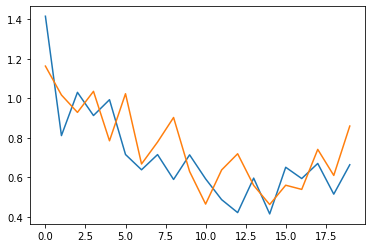

In [130]:
plt.plot(loss_l, label = "train loss")
plt.plot(validloss_l, label = "valid loss")

# test

## test model

In [168]:
def get_img(file_name) :
    # series : data['file_name']
    # root_path : 이미지 파일들이 존재하는 디렉토리 경로 ('./dataset/train/')
    # return : (28,28,1) 형태의 array들이 담긴 list
    


    image_path = file_name
    image = Image.open(image_path)
    image = image.convert('RGB')
    image = image.resize((100, 100))
    image_array = np.array(image)


    reshaped_image = image_array.reshape(100,100,3) #reshape

        
    return np.array(reshaped_image)

In [169]:
def get_transform():

    t = list()
    t.append(transforms.ToTensor())
    
    # if mode == 'train':
    #     t.append(transforms.RandomAffine(degrees=10, translate=(0.1,0.1)))

    t.append(transforms.Normalize(mean=(.5),std=(.5)))
    
    return transforms.Compose(t)

In [170]:
trans= get_transform()

file path: /content/drive/MyDrive/data/archive/bee_imgs/bee_imgs/001_078.png
label of test data:  healthy


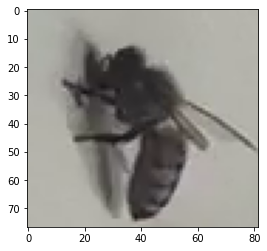

In [208]:
test_path = '/content/drive/MyDrive/data/archive/bee_imgs/bee_imgs/001_078.png'
print("file path:", test_path)
image_tensor = get_img(test_path)

trans(image_tensor)
output = cnn(trans(image_tensor))

output = F.softmax(output, dim=1)

output = output.tolist()
output = output[0]
output_index = output.index(max(output))
image = Image.open(test_path)
image = np.array(image)
plt.imshow(image)
print("label of test data: ", label_list[output_index])